In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression

import theano
import pymc3 as pm
from pymc3 import plot_posterior

%matplotlib inline

In [0]:
%%capture
%%bash
mkdir data/
wget -P ./data/ https://github.com/sachinruk/bayes_school/raw/master/data/all_stocks_5yr.csv.zip 

The data was downloaded from https://www.kaggle.com/camnugent/sandp500

In [3]:
df = pd.read_csv('./data/all_stocks_5yr.csv.zip', compression='zip')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [4]:
stocks = ['MSFT']
df_stocks = df.loc[df.Name.isin(stocks), ['Date', 'Close', 'Name']]
df_stocks.shape

(1258, 3)

In [5]:
df_stocks = df_stocks.pivot(index='Date', columns='Name', values='Close')
df_stocks.head()

Name,MSFT
Date,
2012-08-13,30.39
2012-08-14,30.13
2012-08-15,30.20
2012-08-16,30.78
2012-08-17,30.90


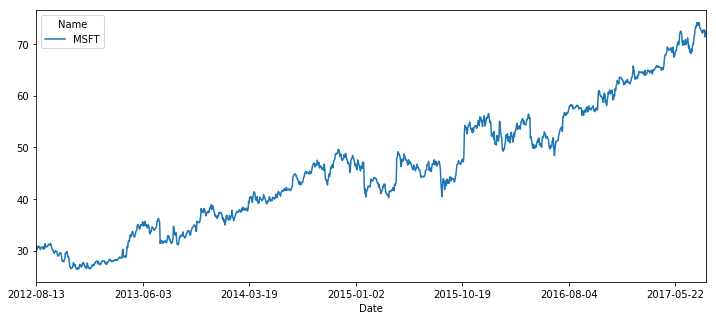

In [6]:
df_stocks.plot(figsize=(12, 5))
plt.show()

## Generating Synthetic data

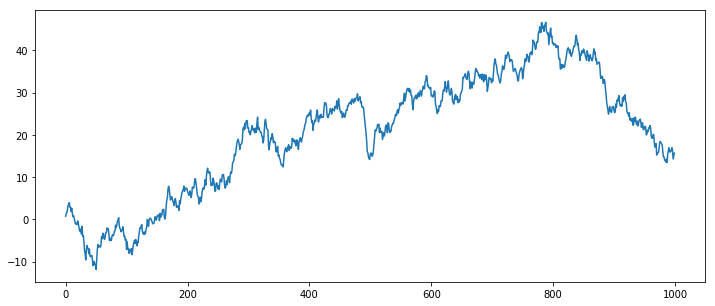

In [7]:
N = 1000
D = 1

e = np.random.randn(N, D)

y2 = np.cumsum(e, axis=0)
plt.figure(figsize=(12, 5))
plt.plot(y2)
plt.show()

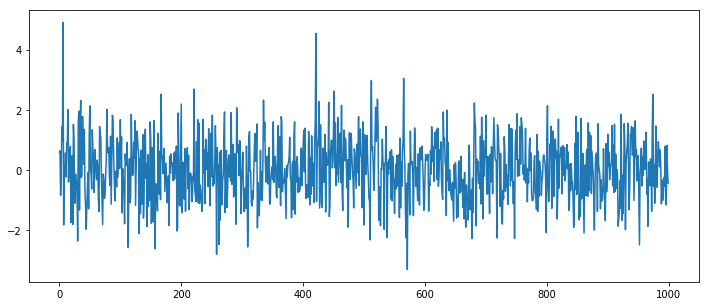

In [31]:
N = 1000
D = 1

e = np.random.randn(N, D)

plt.figure(figsize=(12, 5))
plt.plot(e)
plt.show()

## Inference Process

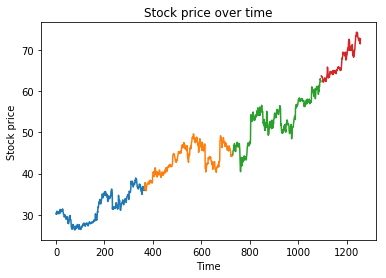

In [8]:
# def inference(y, t, ):
df_stocks['MSFT'].values[:,None]
window=365
N = len(df_stocks)

t_section = np.int64(np.arange(N)) // window
k = t_section.max()+1

t = np.arange(len(df_stocks))

for i in range(k):
    time = t[t_section==i]
    stock_val = df_stocks.loc[t_section==i,'MSFT'].values
    plt.plot(time, stock_val)
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.title('Stock price over time')
plt.show()

## Scikit-Learn Method

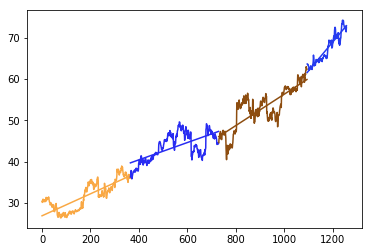

In [9]:
color = np.random.rand(k,3)
for i in range(k):
    time = t[t_section==i][:,None]
    stock_val = df_stocks.loc[t_section==i,'MSFT'].values[:,None]
    model = LinearRegression()
    model.fit(time, stock_val)
    y_pred = model.predict(time)
    
    plt.plot(time, stock_val, c=color[i])
    plt.plot(time, y_pred, c=color[i])
    
plt.show()

In [0]:
y_mean = df_stocks.mean().values
y_std = df_stocks.std().values
y = (df_stocks.values - y_mean) / y_std

t = (t-t.mean())/t.std()

Gaussian process on regression
\begin{align}
\alpha_T &= \alpha_{T-1} + \xi_\alpha \\
\beta_T &= \beta_{T-1} + \xi_\beta \\
\xi_\alpha &\sim \mathcal{N}(0, \sigma_\alpha) \\
\xi_\beta &\sim \mathcal{N}(0, \sigma_\beta) \\
\end{align}
The trend line is donated as being:
$$
\mu = \alpha_T + \beta_T t
$$
While the observations are taken to be:
$$
y_t = \mu + \xi_y\\
\xi_y \sim \mathcal{N}(0, \sigma_y)
$$

In [11]:
t_t = theano.shared(t)
y_t = theano.shared(y.squeeze())
t_section_t = theano.shared(t_section.squeeze())

n_samples=500

with pm.Model() as model:
    sd_α = pm.Uniform('sd_α', lower=0, upper=1)
    sd_β = pm.Uniform('sd_β', lower=0, upper=1)

    α = pm.GaussianRandomWalk('alpha', sigma=sd_α, shape=k)
    β = pm.GaussianRandomWalk('beta', sigma=sd_β, shape=k)
    
    # usual regression
    alpha_r = α[t_section_t]
    beta_r = β[t_section_t]
    regression = alpha_r+beta_r*t_t

    sd = pm.Uniform('sd', 0, 1)
    likelihood = pm.Normal('y', mu=regression, sd=sd, observed=y_t)
    trace = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, alpha, sd_β, sd_α]
100%|██████████| 1000/1000 [00:15<00:00, 64.93it/s]
The acceptance probability does not match the target. It is 0.887559498239886, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926247111090599, but should be close to 0.8. Try to increase the number of tuning steps.


In [32]:
t_section.shape

(1825,)

In [33]:
t_section

array([0, 0, 0, ..., 4, 4, 4])

In [12]:
trace['alpha'].shape

(1000, 4)

In [13]:
trace['sd'].shape

(1000,)

In [0]:
a_mean = trace['alpha'].mean(axis=0)
b_mean = trace['beta'].mean(axis=0)

y_pred = a_mean[t_section] + b_mean[t_section]*t

# Un-normalise the data
y_pred = y_pred*y_std + y_mean
y = df_stocks.values

In [0]:
dates = np.array([np.datetime64(d) for d in df_stocks.index])
stocks = df_stocks.columns.values

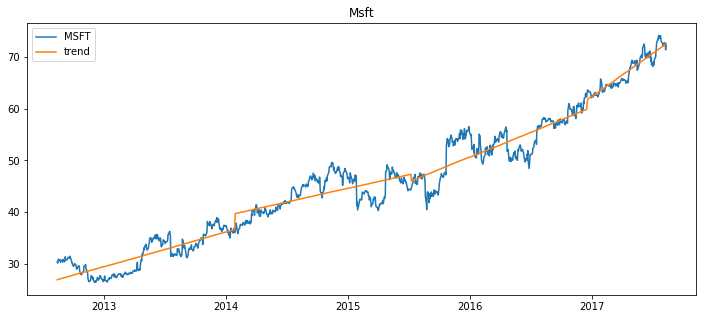

In [16]:
stock = stocks[0]
plt.figure(figsize=(12,5))
plt.plot(dates, y, label=stock)
plt.plot(dates, y_pred, label="trend")
plt.legend()
plt.title(stock.capitalize())
plt.show()

In [17]:
y_pred = trace['alpha'].T[t_section] + trace['beta'].T[t_section]*t[:,None]
y_pred = y_pred.T
y_pred.shape

(1000, 1258)

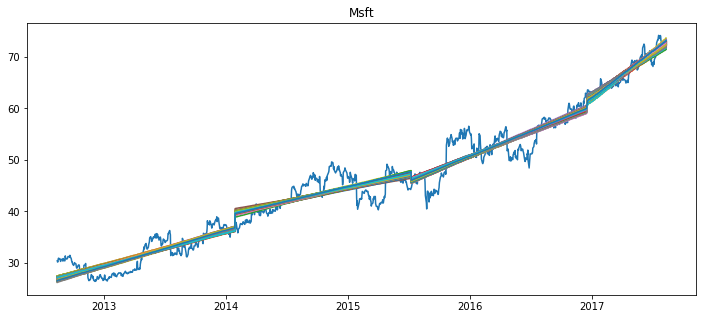

In [18]:
idx = np.random.choice(len(y_pred), 200)

plt.figure(figsize=(12,5))
plt.plot(dates, y, label=stock)
for i in idx:
    trend = y_pred[i]*y_std + y_mean
    plt.plot(dates, trend)

plt.title(stock.capitalize())
plt.show()

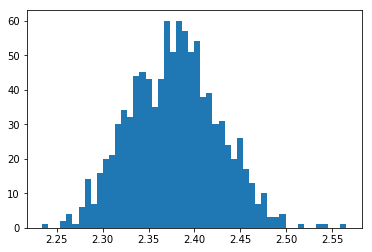

In [19]:
plt.hist(trace['sd']*y_std, 50)
plt.show()

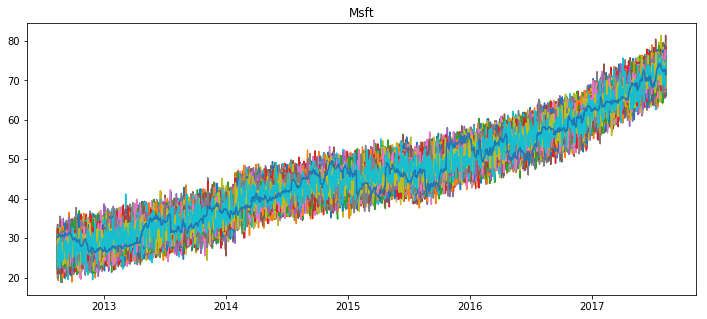

In [20]:
plt.figure(figsize=(12,5))
for i in idx:
    y_obs = y_pred[i] + trace['sd'][i] * np.random.randn((len(y)))
    plt.plot(dates, y_obs*y_std + y_mean)
plt.plot(dates, y, label=stock)
plt.title(stock.capitalize())
plt.show()

In [0]:
y_mean = df_stocks.mean().values
y_std = df_stocks.std().values
y = (df_stocks.values - y_mean) / y_std

t = (t-t.mean())/t.std()

In [22]:
t_t = theano.shared(t)
y_t = theano.shared(y.squeeze())
t_section_t = theano.shared(t_section.squeeze())

n_samples=500

with pm.Model() as model:
    sd_α = pm.Uniform('sd_α', lower=0, upper=1)
    sd_β = pm.Uniform('sd_β', lower=0, upper=1)

    α = pm.GaussianRandomWalk('alpha', sigma=sd_α, shape=k+1)
    β = pm.GaussianRandomWalk('beta', sigma=sd_β, shape=k+1)
    
    # usual regression
    alpha_r = α[t_section_t]
    beta_r = β[t_section_t]
    regression = alpha_r+beta_r*t_t

    sd = pm.Uniform('sd', 0, 1)
    likelihood = pm.Normal('y', mu=regression, sd=sd, observed=y_t)
    trace = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, alpha, sd_β, sd_α]
100%|██████████| 1000/1000 [00:15<00:00, 63.96it/s]


In [0]:
t_section = np.int64(np.arange(window*(k+1))) // window
t = np.arange(len(df_stocks))
t_mean = t.mean()
t_std = t.std()

t = np.arange(len(t_section))
t = (t - t_mean) / t_std

In [24]:
y_pred = trace['alpha'].T[t_section] + trace['beta'].T[t_section]*t[:,None]
y_pred = y_pred.T
y_pred.shape

(1000, 1825)

In [25]:
df_stocks.index[0]

'2012-08-13'

The dates at the bottom are wrong. I forgot that you don't trade on weekends and didn't factor that in. The idea of increased variance is still valid.

In [0]:
base = datetime.datetime(2012, 8, 13)
dates = np.array([base + datetime.timedelta(days=i) for i in range(len(t))])

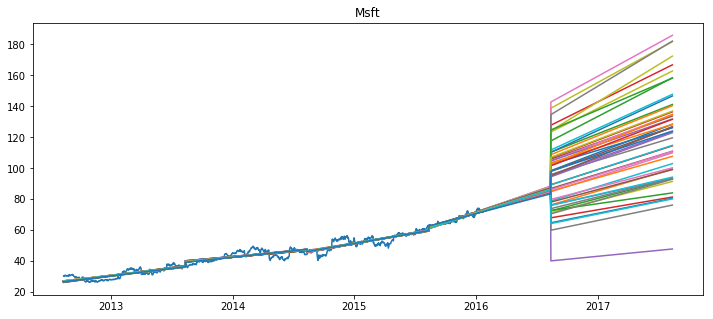

In [27]:
idx = np.random.choice(len(y_pred), 50)

plt.figure(figsize=(12,5))
plt.plot(dates[:len(y)], df_stocks.values, label=stock)
for i in idx:
    plt.plot(dates, y_pred[i]*y_std + y_mean)

plt.title(stock.capitalize())
plt.show()

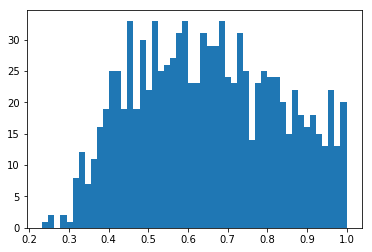

In [30]:
plt.hist(trace['sd_β'], 50)
plt.show()